In [54]:
#Importação das bibliotecas necessárias
import warnings
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score,
    classification_report,
)
import matplotlib.pyplot as plt

In [55]:
### Bloco 2: Carregamento e limpeza dos dados

# Carrega o CSV
file_path = r'C:\Users\JCOQ2V\Desktop\Dados Históricos - Ibovespa.csv'
df = pd.read_csv(file_path)

# Processa a coluna de data
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df.sort_values('Data', inplace=True)
df.reset_index(drop=True, inplace=True)

# Limpeza de colunas numéricas
df['Var%'] = df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)
for c in ['Último', 'Abertura', 'Máxima', 'Mínima']:
    df[c] = (df[c]
             .astype(str)
             .str.replace('.', '', regex=False)
             .str.replace(',', '.', regex=False)
             .astype(float))

# Conversão de volume
def conv_vol(x):
    if isinstance(x, str):
        x_clean = x.replace(',', '.')
        suffix = x_clean[-1]
        mult = {'K': 1e3, 'M': 1e6, 'B': 1e9}.get(suffix, 1)
        return float(x_clean.rstrip('KMB')) * mult
    return x

df['Vol.'] = df['Vol.'].apply(conv_vol)

In [56]:
#Selecionar dados a partir de 2011 onde se demonstra mais estável, após recuperação do vale de 2009

df = df[df['Data'].dt.year > 2010].reset_index(drop=True)


In [57]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2011-01-03,69962.0,6931.0,70471.0,69305.0,1860000.0,0.95
1,2011-01-04,70318.0,69962.0,70318.0,6956.0,2430000.0,0.51
2,2011-01-05,71091.0,70311.0,71173.0,69802.0,2310000.0,1.10
3,2011-01-06,70579.0,71092.0,71167.0,70469.0,2550000.0,-0.72
4,2011-01-07,70057.0,7058.0,70783.0,69718.0,1760000.0,-0.74


In [58]:
#indexar colunas no lugar da data e remover nulos
df = df[['Último', "Máxima", "Mínima", "Abertura", "Vol."]].dropna().reset_index()
df.columns = ['Data', 'Último', 'Máxima', 'Mínima', 'Abertura', 'Vol.']
df_model = df.dropna().copy()

In [59]:
df.head()

,Data,Último,Máxima,Mínima,Abertura,Vol.
0,0,69962.0,70471.0,69305.0,6931.0,1860000.0
1,1,70318.0,70318.0,6956.0,69962.0,2430000.0
2,2,71091.0,71173.0,69802.0,70311.0,2310000.0
3,3,70579.0,71167.0,70469.0,71092.0,2550000.0
4,4,70057.0,70783.0,69718.0,7058.0,1760000.0


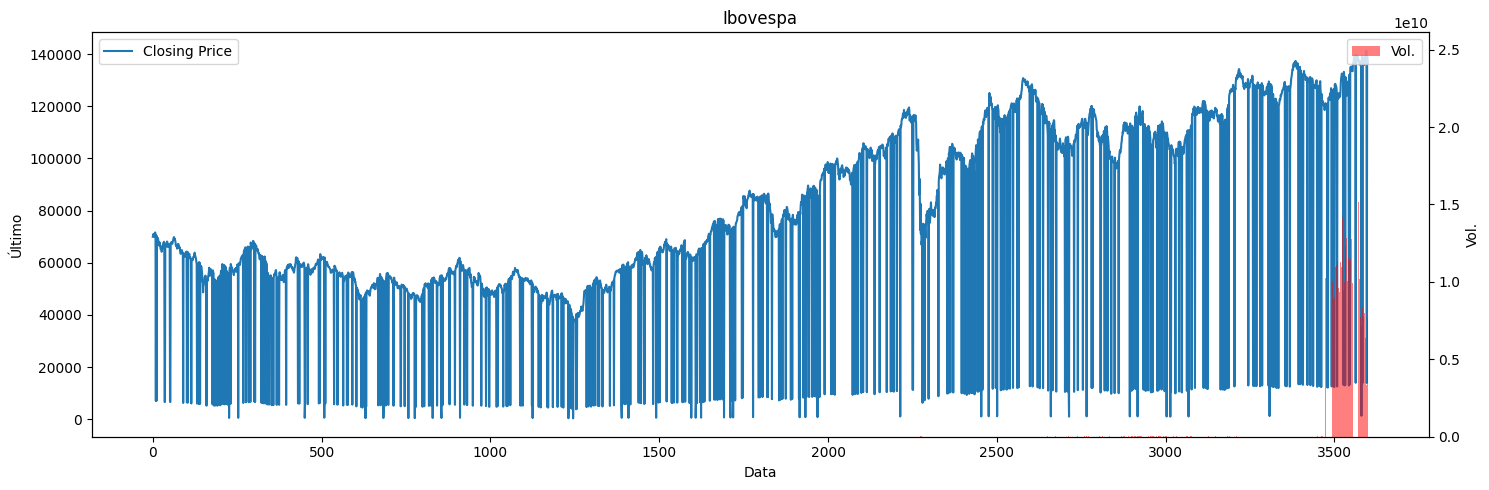

In [60]:
#Acompanhamento do fechamento e do do Volume
ax = df.plot(x='Data', y='Último', kind='line', label='Closing Price')
ax.set_title('Ibovespa')
ax.set_xlabel('Data')
ax.set_ylabel('Último')
fig = ax.get_figure()
fig.set_figwidth(15)
fig.set_figheight(5)

ax2 = ax.twinx()
ax2.bar(df['Data'], df['Vol.'], alpha=0.5, color='red', label='Vol.')
ax2.set_ylabel('Vol.')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

In [61]:
#criação de um dataset
dataset = pd.DataFrame()

In [62]:
#Adição do fechamento
dataset["Último"] = df["Último"]

#Delta shiftado
delta = df['Último'].diff()
dataset["Delta"] = delta.shift(1)

# desconsidera variações menores que 0.5%
threshold = 0.005  
dataset['Target'] = np.where(
    delta > threshold, 1, np.where(delta < -threshold, 0, np.nan)
)

In [64]:
#Retorno pct
dataset['Return'] = dataset['Último'].pct_change().shift(1)

In [65]:
#Lags
def make_lags(series: pd.Series, n_lags):
    return series.shift(n_lags)


def make_n_lags(df, n_lags, column):
    for i in range(1, n_lags + 1):
        df[f"{column}_lag{i}"] = df[column].shift(i)
    return df

In [66]:
# de 1 a 10
n_lags = 10

dataset = make_n_lags(dataset, n_lags, 'Target')

In [67]:
#Features de Mínima e Máxima Shiftados
dataset["Máxima"] = df["Máxima"].shift(1)
dataset["Mínima"] = df["Mínima"].shift(1)

In [68]:
#Features volatilidade simples
dataset["Volatilidade"] = df["Máxima"] - df["Mínima"]
dataset["Volatilidade_relativa"] = dataset["Volatilidade"] / dataset["Mínima"]

In [100]:
#Feature abertura do df pro dataset
dataset["Abertura"] = df["Abertura"]

In [70]:
# Feature 1 semana útil 5 dias
dataset['MA5'] = df['Último'].rolling(window=5).mean().shift(1)

# Feature 1 mês útil 22 dias
dataset['MA22'] = df['Último'].rolling(window=22).mean().shift(1)

# Feature 1 trimestre útil 66 dias
dataset['MA66'] = df['Último'].rolling(window=66).mean().shift(1)

# Feature 1 semestre útil 132 dias
dataset['MA132'] = df['Último'].rolling(window=132).mean().shift(1)

# Feature 1 ano útil 252 dias
dataset['MA252'] = df['Último'].rolling(window=252).mean().shift(1)

# Feature ATR - variação do preço nos últimos 14 dias
high_low = df['Máxima'] - df['Mínima']
high_prev_close = (df['Máxima'] - df['Último'].shift(1)).abs()
low_prev_close  = (df['Mínima'] - df['Último'].shift(1)).abs()
true_range = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
df['ATR14'] = true_range.rolling(14).mean()
dataset['ATR14'] = df['ATR14'].shift(1)

# 5) Feature Stochastic Oscillator (14,3) - Demonstra se o preço está perto da máxima ou da mínima nos últimos 14 dias
low14 = df['Mínima'].rolling(window=14).min()
high14 = df['Máxima'].rolling(window=14).max()
df['STOCHK'] = 100 * (df['Último'] - low14) / (high14 - low14)
df['STOCHD'] = df['STOCHK'].rolling(window=3).mean()
#dataset['STOCHK'] = df['STOCHK'].shift(1)
#dataset['STOCHD'] = df['STOCHD'].shift(1)

In [71]:
#Drop de nulos
dataset.drop("Último", axis=1, inplace=True)
df_model = dataset.dropna().copy()

In [72]:
# 30 dias como teste
train = df_model.iloc[:-30]
test = df_model.iloc[-30:]

predictors = list(train.columns)
predictors.remove('Target')

X_train, X_test = train[predictors], test[predictors]
y_train, y_test = train['Target'], test['Target']

In [73]:
#Separar em blocos
tscv = TimeSeriesSplit(n_splits=5)

In [74]:
#Experimentar regressão linear
pipe_lr = Pipeline(
    [('scaler', StandardScaler()), ('clf', LogisticRegression(solver='liblinear'))]
)

param_grid_lr = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],  # regularização
    'clf__penalty': ['l1', 'l2'],  # tipo de penalização
    'clf__solver': ['liblinear'],  # necessário para suportar l1
}

grid_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=tscv)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear']})

In [75]:
#Experimentar XGBoost
pipe_xgb = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier()),
    ]
)

param_grid_xgb = {
    'clf__n_estimators': [50, 100, 200],  # número de árvores
    'clf__max_depth': [3, 5, 7],  # profundidade da árvore
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.3],  # taxa de aprendizado
    'clf__subsample': [0.6, 0.8, 1.0],  # fração das amostras usadas em cada árvore
    'clf__colsample_bytree': [0.6, 0.8, 1.0],  # fração de colunas usadas por árvore
    'clf__gamma': [0, 0.1, 0.5, 1.0],  # regularização mínima para divisão
    'clf__reg_alpha': [0, 0.1, 1],  # L1 regularization
    'clf__reg_lambda': [0.1, 1, 10],  # L2 regularization
}

grid_xgb = RandomizedSearchCV(pipe_xgb, param_grid_xgb, cv=tscv)
grid_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('clf',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metr...
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None, ...))]),
                   param_distributions={'clf__colsample_bytree': [0.6, 0.8,
                                                                  1.0],
                                        'clf__gamma': [0, 0.1, 0.5, 1.0],
                                        'clf__learning_rate': [0.01, 0.05, 0.1,
                                                               0.3],
                                        'clf__max_depth': [3, 5, 7],
                                        'clf__n_estimators': [50, 100, 200],
                                        'clf__reg_alpha': [0, 0.1, 1],
                                        'clf__reg_lambda': [0.1, 1, 10],
                                        'clf__subsample': [0.6, 0.8, 1.0]})

In [76]:
#Resultados Regressão
print("Logistic Regression:")
print("Melhores parâmetros:", grid_lr.best_params_)
print("Acurácia:", accuracy_score(y_test, grid_lr.predict(X_test)))
print(classification_report(y_test, grid_lr.predict(X_test)))

Logistic Regression:
Melhores parâmetros: {'clf__C': 1, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Acurácia: 0.6
              precision    recall  f1-score   support

         0.0       0.63      0.71      0.67        17
         1.0       0.55      0.46      0.50        13

    accuracy                           0.60        30
   macro avg       0.59      0.58      0.58        30
weighted avg       0.59      0.60      0.59        30



In [77]:
#Resultados XGBoost
print("\nXGBoost:")
print("Melhores parâmetros:", grid_xgb.best_params_)
print("Acurácia:", accuracy_score(y_test, grid_xgb.predict(X_test)))
print(classification_report(y_test, grid_xgb.predict(X_test)))


XGBoost:
Melhores parâmetros: {'clf__subsample': 1.0, 'clf__reg_lambda': 1, 'clf__reg_alpha': 1, 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf__gamma': 0.1, 'clf__colsample_bytree': 1.0}
Acurácia: 0.7666666666666667
              precision    recall  f1-score   support

         0.0       0.75      0.88      0.81        17
         1.0       0.80      0.62      0.70        13

    accuracy                           0.77        30
   macro avg       0.78      0.75      0.75        30
weighted avg       0.77      0.77      0.76        30



In [78]:
#Resultados baseline
baseline_pred = y_test.shift(1).diff().dropna().apply(np.sign) + 1

# calculando a acurácia do baseline
baseline_accuracy = accuracy_score(y_test.loc[baseline_pred.index], baseline_pred)
print(f"Acurácia do baseline: {baseline_accuracy:.2f}")

Acurácia do baseline: 0.21


In [79]:
# acurácia dos modelos

# regressão logística
log_reg_accuracy = accuracy_score(y_test, grid_lr.predict(X_test))

# xgboost
xgb_accuracy = accuracy_score(y_test, grid_xgb.predict(X_test))

# criando a tabela de comparação
tabela_comparativa = pd.DataFrame(columns=['Modelo', 'Acurácia'])

tabela_comparativa.loc[0] = ['Baseline', f"{baseline_accuracy*100:.2f}%"]
tabela_comparativa.loc[1] = ['Logistic Regression', f"{log_reg_accuracy*100:.2f}%"]
tabela_comparativa.loc[2] = ['XGBoost', f"{xgb_accuracy*100:.2f}%"]

tabela_comparativa

,Modelo,Acurácia
0,Baseline,21.43%
1,Logistic Regression,60.00%
2,XGBoost,76.67%


In [80]:
df_model.tail()

,Delta,Target,Return,Target_lag1,Target_lag2,Target_lag3,Target_lag4,Target_lag5,Target_lag6,Target_lag7,...,Mínima,Volatilidade,Volatilidade_relativa,Abertura,MA5,MA22,MA66,MA132,MA252,ATR14
3594,1877.0,1.0,0.013499,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,139051.0,967.0,0.006954,140928.0,139049.8,125707.227273,122073.151515,117428.803030,116546.075397,37559.214286
3595,336.0,0.0,0.002384,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,140597.0,2047.0,0.014559,141265.0,139929.4,125876.227273,122215.000000,117584.045455,116611.734127,27970.571429
3596,-127315.0,1.0,-0.901256,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,139295.0,125714.0,0.902502,139491.0,114948.2,120282.909091,122228.984848,116771.628788,116171.900794,27918.500000
3597,125354.0,0.0,8.986594,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,13877.0,2032.0,0.146429,139303.0,114899.0,120422.318182,122352.560606,116901.939394,116226.031746,36812.071429
3598,-1822.0,0.0,-0.013079,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,137299.0,1458.0,0.010619,137472.0,114585.0,120485.000000,124236.833333,117028.560606,116270.940476,28008.857143


In [86]:
# Validação com parametros experimentados

from sklearn.model_selection import cross_val_score

# Parâmetros 
best_params = {
    'n_estimators': 120,
    'max_depth': 3,
    'learning_rate': 0.1,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.1,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0
}

# Pipeline com XGBoost final
xgb_final = XGBClassifier(**best_params)
pipe_final_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', xgb_final)
])

# 1) Validação temporal para avaliar estabilidade
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(
    pipe_final_xgb,
    X_train, y_train,
    cv=tscv,
    scoring='accuracy',
    n_jobs=-1
)
print(f"TimeSeriesSplit Accuracy → média: {scores.mean():.2%}, desvio: {scores.std():.2%}")

# 2) Refit no conjunto inteiro de treino
pipe_final_xgb.fit(X_train, y_train)

# 3) Avaliação no hold‑out
y_pred_final = pipe_final_xgb.predict(X_test)
print(f"Acurácia final do XGBoost (hold‑out): {accuracy_score(y_test, y_pred_final):.2%}")
print(classification_report(y_test, y_pred_final))


TimeSeriesSplit Accuracy → média: 59.24%, desvio: 1.51%
Acurácia final do XGBoost (hold‑out): 76.67%
              precision    recall  f1-score   support

         0.0       0.75      0.88      0.81        17
         1.0       0.80      0.62      0.70        13

    accuracy                           0.77        30
   macro avg       0.78      0.75      0.75        30
weighted avg       0.77      0.77      0.76        30



<Figure size 600x500 with 0 Axes>

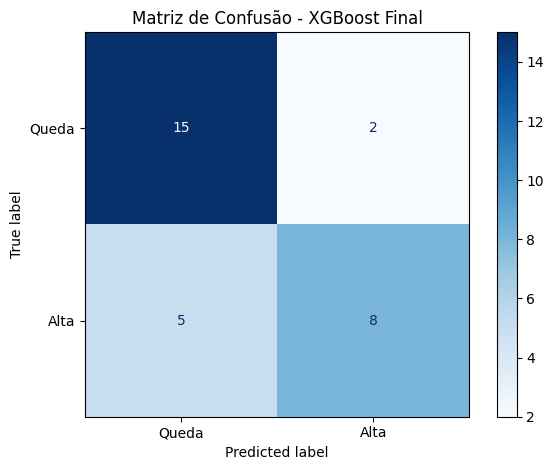

In [87]:
# bloco 24 – Matriz de Confusão

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Queda", "Alta"])

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - XGBoost Final')
plt.grid(False)
plt.tight_layout()
plt.show()


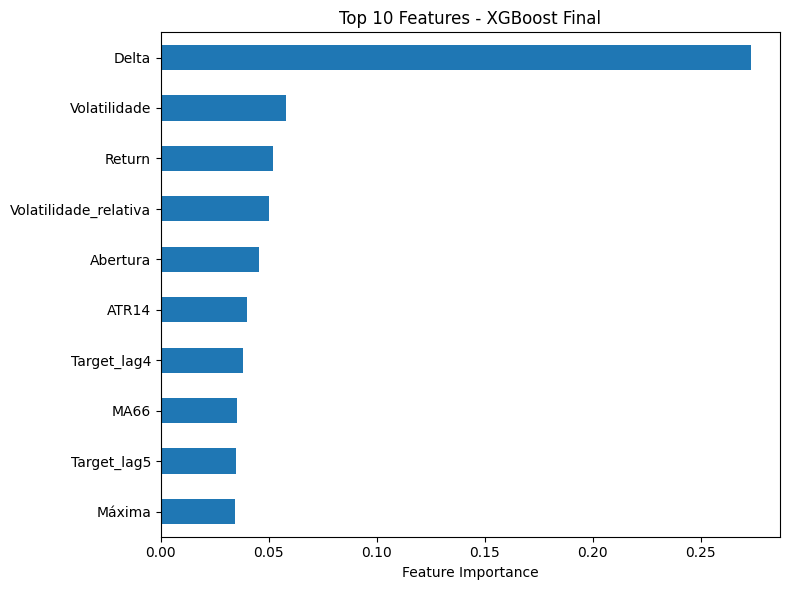

In [97]:
# bloco 25 – Gráfico das melhores features do XGBoost final

import matplotlib.pyplot as plt
import pandas as pd

# Extrai o modelo XGBoost ajustado
final_clf = pipe_final_xgb.named_steps['clf']

# Obtém importâncias e monta uma Series
fi = pd.Series(final_clf.feature_importances_, index=predictors)
fi_sorted = fi.sort_values(ascending=False)

# Define quantas exibir (por exemplo, top 10)
top_n = 10
fi_top = fi_sorted.head(top_n)

# Plota
plt.figure(figsize=(8, 6))
fi_top.plot(kind='barh')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Features - XGBoost Final')
plt.tight_layout()
plt.show()


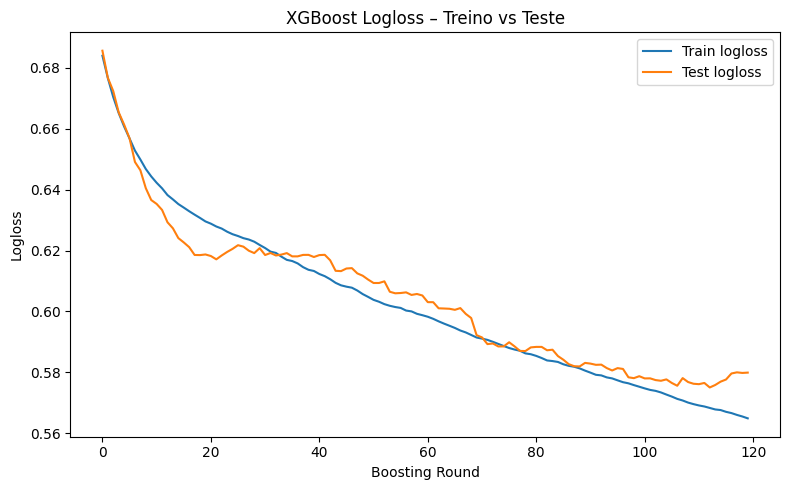

In [90]:
# bloco 25 – Gráfico de logloss para checar overfitting no XGBoost 

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# 1) Escala os dados
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2) Instancia o modelo com logloss no construtor
clf = XGBClassifier(**best_params, eval_metric='logloss')

# 3) Ajusta com avaliação em train e test (sem passar eval_metric aqui)
eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
clf.fit(
    X_train_scaled, y_train,
    eval_set=eval_set,
    verbose=False
)

# 4) Recupera os resultados de avaliação
results = clf.evals_result()

# 5) Plota logloss de treino vs teste
plt.figure(figsize=(8, 5))
plt.plot(results['validation_0']['logloss'], label='Train logloss')
plt.plot(results['validation_1']['logloss'], label='Test logloss')
plt.xlabel('Boosting Round')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss – Treino vs Teste')
plt.legend()
plt.tight_layout()
plt.show()


In [99]:
# bloco 26 – Tabela dos últimos 30 dias

dias = np.arange(1, len(test) + 1)

# 2) Setas para movimento real e previsto
actual_arrow    = test['Target'].map({1: '↑', 0: '↓'}).values
predicted_arrow = pd.Series(y_pred_final, index=test.index).map({1: '↑', 0: '↓'}).values

# 3) Emoji de resultado
result_emoji = np.where(test['Target'].values == y_pred_final, '🟩', '🟥')

# 4) Monta o DataFrame
tabela_30 = pd.DataFrame({
    'Dia':       dias,
    'Real':      actual_arrow,
    'Previsto':  predicted_arrow,
    'Resultado': result_emoji
})

# 5) Exibe
print(tabela_30)


    Dia Real Previsto Resultado
0     1    ↓        ↓         🟩
1     2    ↓        ↑         🟥
2     3    ↓        ↑         🟥
3     4    ↑        ↑         🟩
4     5    ↓        ↓         🟩
5     6    ↓        ↓         🟩
6     7    ↓        ↓         🟩
7     8    ↓        ↓         🟩
8     9    ↑        ↑         🟩
9    10    ↑        ↓         🟥
10   11    ↓        ↓         🟩
11   12    ↑        ↑         🟩
12   13    ↑        ↓         🟥
13   14    ↓        ↓         🟩
14   15    ↑        ↑         🟩
15   16    ↓        ↓         🟩
16   17    ↓        ↓         🟩
17   18    ↑        ↑         🟩
18   19    ↓        ↓         🟩
19   20    ↑        ↑         🟩
20   21    ↓        ↓         🟩
21   22    ↑        ↑         🟩
22   23    ↑        ↓         🟥
23   24    ↓        ↓         🟩
24   25    ↑        ↓         🟥
25   26    ↑        ↓         🟥
26   27    ↓        ↓         🟩
27   28    ↑        ↑         🟩
28   29    ↓        ↓         🟩
29   30    ↓        ↓         🟩


In [101]:
# obtém probabilidades de alta e de baixa
proba_up   = pipe_final_xgb.predict_proba(new_X)[0][1]
proba_down = 1 - proba_up

# seta conforme maior probabilidade
arrow = '↑' if proba_up > proba_down else '↓'

print(f"Previsão para amanhã: {arrow}")



Previsão para amanhã: ↓
